In [2]:
# modelling imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from joblib import dump, load

# Voila app imports
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import GridBox, Layout

## Dataset

y: has the client subscribed a term deposit? (binary: 'yes','no')<br>
poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success','unknown')<br>
default: has credit in default? (categorical: 'no','yes',)<br>
housing: has housing loan? (categorical: 'no','yes')<br>
marital: self-explanatory<br>
job: self-explanatory

In [3]:
df = pd.read_csv("bank-full.csv", skiprows=0, delimiter=";")
df = df[["job", "marital", "default", "housing", "poutcome", "y"]]

In [4]:
le = LabelEncoder()
label = le.fit_transform(df["y"])
df.drop("y", axis=1, inplace=True)
df["y"] = label

In [5]:
df["marital"].unique()

array(['married', 'single', 'divorced'], dtype=object)

## Sorting widgets

In [6]:
ALL = "ALL"


def unique_values_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)  # insert ALL option
    return unique

In [7]:
# widgets

output = widgets.Output()

plot_output = widgets.Output()

job_dropdown = widgets.Dropdown(
    options=unique_values_ALL(df["job"]), value="ALL", description="client job"
)
outcome_dropdown = widgets.Dropdown(
    options=unique_values_ALL(df["poutcome"]),
    value="ALL",
    description="outcomes",
)

# ------------event handlers-----------------------


def job_dropdown_handler(change):
    shared_filter(change.new, outcome_dropdown.value)


def outcome_dropdown_handler(change):
    shared_filter(job_dropdown.value, change.new)


# -----------filter--------------------------------


def shared_filter(job, outcome):
    output.clear_output(wait=True)
    plot_output.clear_output()

    if (job == "ALL") and (outcome == "ALL"):
        filter = df

    elif job == "ALL":
        filter = df[df.poutcome == outcome]

    elif outcome == "ALL":
        filter = df[df.job == job]

    else:
        filter = df[(df.job == job) & (df.poutcome == outcome)]

    with output:
        display(filter)

    with plot_output:
        sns.kdeplot(filter["y"].astype(float), shade=True)
        plt.show()


# --------------------------------------------------

# binding
job_dropdown.observe(job_dropdown_handler, names="value")
outcome_dropdown.observe(outcome_dropdown_handler, names="value")

## Dashboard

In [8]:
item_layout = widgets.Layout(margin="0 0 25px 0", width="500px")

In [9]:
input_widgets = widgets.HBox(
    [job_dropdown, outcome_dropdown], layout=item_layout
)

tab = widgets.Tab([output, plot_output], layout=item_layout)
tab.set_title(0, "Dataset Exploration")
tab.set_title(1, "KDE Plot")

dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)

## Model

In [10]:
d = {}
for i, key in enumerate(df["job"].unique()):
    d[key] = i + 1
d

{'management': 1,
 'technician': 2,
 'entrepreneur': 3,
 'blue-collar': 4,
 'unknown': 5,
 'retired': 6,
 'admin.': 7,
 'services': 8,
 'self-employed': 9,
 'unemployed': 10,
 'housemaid': 11,
 'student': 12}

In [11]:
def process(df):
    d = {}
    for i, key in enumerate(df["job"].unique()):
        d[key] = i + 1

    numeric_var = {
        "poutcome": {"success": 4, "failure": 3, "other": 2, "unknown": 1},
        "job": d,
    }
    df = df.replace(numeric_var)
    housing = le.fit_transform(df["housing"])
    marital = le.fit_transform(df["marital"])
    default = le.fit_transform(df["default"])

    df.drop(["housing", "marital", "default"], axis=1, inplace=True)
    df = df.assign(housing=housing, marital=marital, default=default)

    return df

In [15]:
data = process(df)
X = data.drop("y", axis=1)
y = data["y"]

In [16]:
print(X.shape, y.shape)

(45211, 5) (45211,)


In [14]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [19]:
data.head()

,job,poutcome,y,housing,marital,default
0,1,1,0,1,1,0
1,2,1,0,1,2,0
2,3,1,0,1,1,0
3,4,1,0,1,1,0
4,5,1,0,0,2,0


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>]], dtype=object)

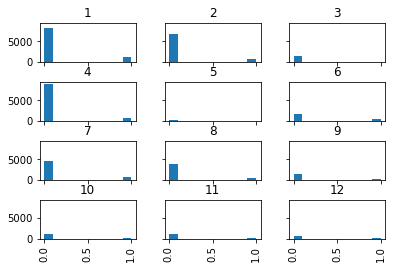

In [20]:
data.y.hist(by=data.job, sharey=True, sharex=True)

In [15]:
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8793541966161672


In [16]:
dump(svc, "linear_svm.joblib")

['linear_svm.joblib']

## Plotter function

In [17]:
def plotly_hist(df, jobtype, poutcome, prediction=1):

    plot1 = df[df.job]["y"].astype(int)
    plot2 = df[(df.poutcome == poutcome) & (df.job == jobtype)]["y"].astype(
        int
    )

    fig = go.Figure()

    fig.add_trace(
        go.Histogram(
            x=plot_series1,
            name="All Fields",
            histnorm="percent",
            xbins=dict(size=1000),
        )
    )
    fig.add_trace(
        go.Histogram(
            x=plot_series2,
            name=majorfield,
            histnorm="percent",
            xbins=dict(size=1000),
        )
    )
    fig.add_vline(
        x=prediction,
        line_dash="dash",
        annotation_text=f"Predicted: ${round(prediction, 2):,}",
    )

    fig.update_traces(opacity=0.55)
    return fig

## user input widgets

In [18]:
jobs = sorted(list(df["job"].unique()))
marital = sorted(list(df["marital"].unique()))
default = sorted(list(df["default"].unique()))
housing = sorted(list(df["housing"].unique()))
poutcome = sorted(list(df["poutcome"].unique()))

In [19]:
job_widget = widgets.Dropdown(
    options=jobs,
    value="admin.",
    description="job:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="80%"),
)
marital_widget = widgets.Dropdown(
    options=marital,
    value="married",
    description="marital status:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="80%"),
)
default_widget = widgets.Dropdown(
    options=default,
    value="no",
    description="defaults:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="80%"),
)
housing_widget = widgets.Dropdown(
    options=housing,
    value="yes",
    description="housing loan:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="80%"),
)
poutcome_widget = widgets.Dropdown(
    options=poutcome,
    value="unknown",
    description="marital status:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="80%"),
)

## predictions

In [20]:
def results(job, marital, default, housing, poutcome):
    df_new = pd.DataFrame(
        [[job, marital, default, housing, poutcome]],
        columns=["job", "marital", "default", "housing", "poutcome"],
    )
    df_new_train = pd.get_dummies(
        df_new, columns=["job", "marital", "default", "housing", "poutcome"]
    )
    [[prediction]] = svc.predict(df_new_train)
    pred = prediction if prediction > 0 else np.nan
    return pred

In [ ]:
out = widgets.interactive_output(
    results,
    {
        "job": job_widget,
        "marital": marital_widget,
        "default": default_widget,
        "housing": housing_widget,
        "poutcome": poutcome_widget,
    },
)

In [ ]:
df.poutcome